## Tabular models
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson4-tabular.ipynb

* Using neural nets over traditional ML algos (GBMs) make feature engineering a lot easier
* Performance is better too, contrary to popular wisdom of late

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.tabular import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

* Specify `dependent`, `categorical`, and `continuous` variables
* List feature engineering pre `processes`

`FillMissing` imputes missing values and adds another column saying whether it was missing or not.  
`Categorify` turns the cat fields into pandas categoricals.  
`Normalize` takes continuous variables and subtracts their mean and divides by standard deviation.  

* `procs` are applied to training, validation and test sets

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [6]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
salary             object
dtype: object

### Datetimes
Feature engineering from `fastai.tabular.transform`
* Example usage shown below

In [418]:
dt = pd.DataFrame()
dt['date'] = pd.date_range(start='1/1/2018', end='1/08/2018', freq='D')

add_datepart(dt, 'date', drop=False)
add_cyclic_datepart(dt, 'date')

dt.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,...,Is_year_start,Elapsed,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin
0,2018,1,1,1,0,1,False,True,False,True,...,True,1514764800,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,0.000000
1,2018,1,1,2,1,2,False,False,False,False,...,False,1514851200,0.623490,0.781831,0.979530,0.201299,1.0,0.0,0.999852,0.017213
2,2018,1,1,3,2,3,False,False,False,False,...,False,1514937600,-0.222521,0.974928,0.918958,0.394356,1.0,0.0,0.999407,0.034422
3,2018,1,1,4,3,4,False,False,False,False,...,False,1515024000,-0.900969,0.433884,0.820763,0.571268,1.0,0.0,0.998667,0.051620
4,2018,1,1,5,4,5,False,False,False,False,...,False,1515110400,-0.900969,-0.433884,0.688967,0.724793,1.0,0.0,0.997630,0.068802


In [7]:
# Taken from pandas profiler

dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'sex', 
             'native-country', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']

procs = [FillMissing, Categorify, Normalize]


In [8]:
from sklearn.model_selection import train_test_split

# ====================================================== # 
#                   Train/test Split                     #
# ====================================================== # 

X_train, X_test, y_train, y_test = train_test_split(df.drop(dep_var, axis=1),
                                                    df[dep_var],
                                                    test_size=0.1,
                                                    random_state=42)

train_df = pd.DataFrame(pd.concat([X_train, y_train], axis=1))
test_df = pd.DataFrame(pd.concat([X_test, y_test], axis=1))

print(train_df.shape)
print(test_df.shape)

(29304, 15)
(3257, 15)


In [9]:
# (Old) tutorial method 

# test = TabularList.from_df(df.iloc[800:1000].copy(), path=path,
#                            cat_names=cat_names, cont_names=cont_names)

In [10]:
test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names)

# test[0]

In [11]:
# ====================================================== # 
#                      Databunch                         #
# ====================================================== # 

data = (TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.2, seed=1)      # create validation set
                           .label_from_df(cols=dep_var)         # specify target
                           .add_test(test)                      # include test set
                           .databunch())


In [12]:
data

TabularDataBunch;

Train: LabelList (23444 items)
x: TabularList
workclass  Private; education  Bachelors; marital-status  Never-married; occupation  Prof-specialty; sex  Male; native-country  United-States; relationship  Not-in-family; race  White; education-num_na False; age -1.2151; fnlwgt 1.1866; education-num 1.1404; hours-per-week -0.0370; capital-gain -0.1461; capital-loss -0.2185; ,workclass  Private; education  Bachelors; marital-status  Divorced; occupation  Exec-managerial; sex  Male; native-country  United-States; relationship  Not-in-family; race  White; education-num_na False; age 1.0632; fnlwgt 0.8054; education-num 1.1404; hours-per-week 2.3941; capital-gain -0.1461; capital-loss -0.2185; ,workclass  Private; education  HS-grad; marital-status  Never-married; occupation  Handlers-cleaners; sex  Female; native-country  United-States; relationship  Own-child; race  White; education-num_na False; age -1.2151; fnlwgt -0.8609; education-num -0.4152; hours-per-week -0.0370; c

In [13]:
data.show_batch(rows=5)

workclass,education,marital-status,occupation,sex,native-country,relationship,race,education-num_na,age,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,target
Private,Some-college,Widowed,Prof-specialty,Female,Hungary,Not-in-family,White,False,1.9450,-0.1669,-0.0263,-1.6578,0.1105,-0.2185,<50k
Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Male,?,Husband,White,False,-0.5536,-0.4276,1.1404,1.5837,-0.1461,-0.2185,>=50k
Private,Bachelors,Separated,Sales,Male,United-States,Not-in-family,White,False,0.9162,-0.1691,1.1404,-0.0370,-0.1461,-0.2185,<50k
Private,Masters,Married-civ-spouse,Adm-clerical,Male,South,Husband,Asian-Pac-Islander,True,1.5776,-0.9915,-0.0263,0.7733,-0.1461,-0.2185,>=50k
Private,9th,Never-married,Priv-house-serv,Female,United-States,Not-in-family,Black,False,1.7246,-0.4041,-1.9709,-1.4957,0.0004,-0.2185,<50k


In [14]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [136]:
# Create learner

learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, AUROC()])
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(3, 3)
    (5): Embedding(42, 13)
    (6): Embedding(7, 5)
    (7): Embedding(6, 4)
    (8): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=61, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

### Learning rate finder 
https://sgugger.github.io/the-1cycle-policy.html
* A good learning rate is where the slope of `lr_find` is at it's maximum
* Cyclical learning rates are good for image processing (not needed as much in tabular)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


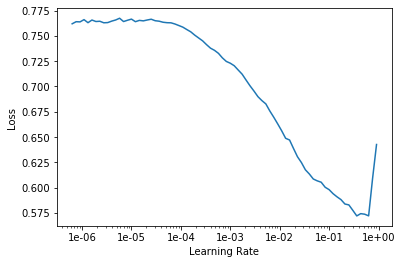

In [16]:
# Learning Rate Finder (cyclical learning rate used in unstructured problems)

# https://towardsdatascience.com/10-new-things-i-learnt-from-fast-ai-v3-4d79c1f07e33

learn.lr_find()
learn.recorder.plot()

In [137]:
learn.fit(1, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.335157,0.333651,0.843174,0.902967,00:40


In [138]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.335498,0.324951,0.848805,0.905740,00:39
1,0.325262,0.326187,0.846928,0.904805,00:40
2,0.337383,0.323212,0.855290,0.906310,00:38
3,0.321094,0.327580,0.851707,0.904550,00:40
4,0.315171,0.353629,0.829522,0.902484,00:42


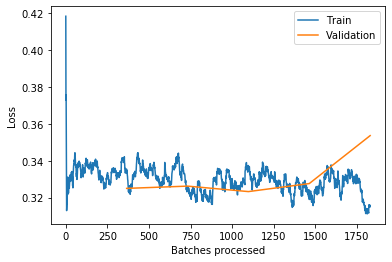

In [139]:
learn.recorder.plot_losses()

In [224]:
learn.fit(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.324355,0.331705,0.846246,0.903992,00:39
1,0.329320,0.328448,0.847782,0.904096,00:38


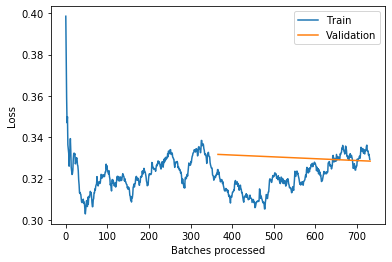

In [225]:
learn.recorder.plot_losses()

### Inference
Single prediction

In [226]:
print(learn.predict(df.iloc[0]))
display(df.head(1))

(Category >=50k, tensor(1), tensor([0.3249, 0.6751]))


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k


### Create dataset for test data
Predict for all `test_df`

In [227]:
test_preds = np.argmax(learn.get_preds(DatasetType.Test)[0],axis=1)
test_preds

tensor([0, 0, 0,  ..., 0, 0, 0])

In [235]:
dx = test_df.copy()
dx['target'] = test_df['salary'].map({'<50k': 0, '>=50k': 1})

dx['nn_preds'] = test_preds
dx.sort_values('nn_preds', ascending=False).head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,target,nn_preds
13618,56,Self-emp-not-inc,323639,Masters,14.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,25,United-States,<50k,0,1
13059,57,Private,173832,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,0,1902,40,United-States,>=50k,1,1
31473,51,Private,168660,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<50k,0,1
3813,27,Private,169460,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<50k,0,1
24755,51,Private,138852,HS-grad,9.0,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<50k,0,1


## Classification Report

In [229]:
from sklearn.metrics import classification_report

y_true = test_df['salary'].map({'<50k': 0, '>=50k': 1})
y_pred = dx['nn_preds']
target_names = ['<50k', '>=50k']

nn_report = classification_report(y_true, y_pred, target_names=target_names)
print(nn_report)

              precision    recall  f1-score   support

        <50k       0.89      0.94      0.91      2525
       >=50k       0.73      0.61      0.67       732

    accuracy                           0.86      3257
   macro avg       0.81      0.77      0.79      3257
weighted avg       0.86      0.86      0.86      3257



In [140]:
def plot_feature(column):
    """Displays aggregated dataframe with count and conversion"""
    gp = dx.groupby(column)['nn_preds'].agg(['mean', 'sum']).reset_index()
    display(gp.style.bar(subset=['mean', 'sum'], color=['#adcae6']))

plot_feature('occupation')

,occupation,mean,sum
0,?,0.0159574,3
1,Adm-clerical,0.0161725,6
2,Craft-repair,0.0141844,6
3,Exec-managerial,0.344059,139
4,Farming-fishing,0.010101,1
5,Handlers-cleaners,0,0
6,Machine-op-inspct,0.00507614,1
7,Other-service,0,0
8,Priv-house-serv,0,0
9,Prof-specialty,0.283951,115


In [141]:
plot_feature('race')

,race,mean,sum
0,Amer-Indian-Eskimo,0,0
1,Asian-Pac-Islander,0.0941176,8
2,Black,0.0340557,11
3,Other,0.136364,3
4,White,0.102967,288


In [142]:
plot_feature('sex')

,sex,mean,sum
0,Female,0.0188324,20
1,Male,0.132118,290


In [143]:
plot_feature('education')

,education,mean,sum
0,10th,0,0
1,11th,0,0
2,12th,0,0
3,1st-4th,0,0
4,5th-6th,0,0
5,7th-8th,0,0
6,9th,0,0
7,Assoc-acdm,0.0775862,9
8,Assoc-voc,0.12037,13
9,Bachelors,0.249057,132


## LightGBM
`Gradient boosting` framework

In [ ]:
# !pip install lightgbm

In [26]:
import lightgbm as lgb

Extract datasets from fastai `databunch` object.

In [185]:
# Function to transfer fastai databunch (post processed) to dataframe

def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
       
       Alternate access of data is found through `data.train_ds.inner_df`
           however this contains categorical fields which have not yet been numericalised
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals


def get_test_df(tll):
    """Get processed test xs from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
        
       y_vals is removed from the return parameters
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    return x_df


# Test function
x_df, y_vals = get_proc_df(data.valid_ds)
x_df.shape, y_vals.shape

((5860, 15), (5860,))

Extract datasets from fastai `databunch` object.  
* With this api call categorical fields have not yet been numericalised
* LightGBM handles `pandas` categoricals efficiently so that is fine

In [186]:
train_x, train_y = get_proc_df(data.train_ds)
valid_x, valid_y = get_proc_df(data.valid_ds)
test_x = get_test_df(data.test_ds)

# Convert target to bool
train_y = np.array(pd.Series(train_y).map({'<50k': 0, '>=50k': 1}))
valid_y = np.array(pd.Series(valid_y).map({'<50k': 0, '>=50k': 1}))

# Convert to lightGBM dataset
dtrain = lgb.Dataset(data=train_x, label=train_y)
dvalid = lgb.Dataset(data=valid_x, label=valid_y)

print(train_x.shape, valid_x.shape)
train_x.head()

(23444, 15) (5860, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,education-num_na
0,-1.215052,5.0,1.186635,10.0,1.140378,5.0,11.0,2.0,5.0,2.0,-0.14614,-0.218544,-0.037035,39.0,1.0
1,1.063161,5.0,0.805426,10.0,1.140378,1.0,5.0,2.0,5.0,2.0,-0.14614,-0.218544,2.394114,39.0,1.0
2,-1.215052,5.0,-0.860880,12.0,-0.415250,5.0,7.0,4.0,5.0,1.0,-0.14614,-0.218544,-0.037035,39.0,1.0
3,-0.700616,5.0,1.314722,7.0,-1.970878,1.0,8.0,5.0,3.0,1.0,-0.14614,-0.218544,-0.037035,39.0,1.0
4,-0.921089,5.0,1.532876,5.0,-2.748692,5.0,15.0,2.0,5.0,2.0,-0.14614,-0.218544,-0.037035,1.0,1.0


### Setting LightGBM parameters

In [188]:

# ------------------- Run Model ---------------------- #

params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': ['accuracy', 'auc'],
          'learning_rate': 0.1,
          'num_leaves': 255,
          'max_depth': 8}

lgb_model = lgb.train(params,
                      dtrain,
                      num_boost_round=100, 
                      valid_sets=[dtrain, dvalid],
                      early_stopping_rounds=5,
                      verbose_eval=False)

# ---------------------------------------------------- #


In [236]:
dx['lgb_decimal'] = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration)
dx['lgb_preds'] = dx['lgb_decimal'].round()

dx[['lgb_decimal', 'lgb_preds']].head(5)

,lgb_decimal,lgb_preds
14160,0.003139,0.0
27048,0.064854,0.0
28868,0.190095,0.0
5667,0.341582,0.0
7827,0.302123,0.0


### Classification Report

In [221]:
y_true = test_df['salary'].map({'<50k': 0, '>=50k': 1})
y_pred = dx['lgb_preds']
target_names = ['<50k', '>=50k']

lgb_report = classification_report(y_true, y_pred, target_names=target_names)
print(lgb_report)

              precision    recall  f1-score   support

        <50k       0.90      0.94      0.92      2525
       >=50k       0.77      0.65      0.71       732

    accuracy                           0.88      3257
   macro avg       0.84      0.80      0.81      3257
weighted avg       0.87      0.88      0.87      3257



In [230]:
print(nn_report)

              precision    recall  f1-score   support

        <50k       0.89      0.94      0.91      2525
       >=50k       0.73      0.61      0.67       732

    accuracy                           0.86      3257
   macro avg       0.81      0.77      0.79      3257
weighted avg       0.86      0.86      0.86      3257



### Feature Importance
* Can be done (better) with nn using `Permutation Importance`
* Permutation Importance takes a column at a time, shuffles the row values, and see how this affects the overall accuracy of the model
* This is a slightly better method as is tests on unseen data. What is of interest is which feature is important for generalising on unseen data, not which feature allows you to fit the data you train on.
https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

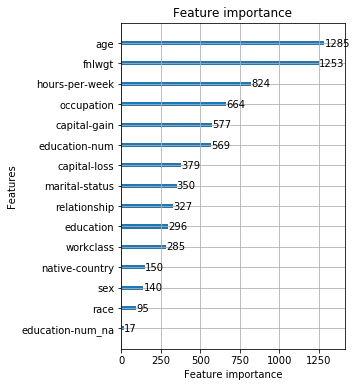

In [223]:
lgb.plot_importance(lgb_model, figsize=(4, 6))

### Plotting

In [293]:
dx.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,target,nn_preds,lgb_decimal,lgb_preds
14160,30,Private,81282,HS-grad,9.0,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<50k,0,0,0.003139,0.0
27048,38,Federal-gov,172571,Some-college,10.0,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,>=50k,1,0,0.064854,0.0
28868,40,Private,223548,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,Mexico,<50k,0,0,0.190095,0.0


In [299]:
plt.style.use('seaborn')

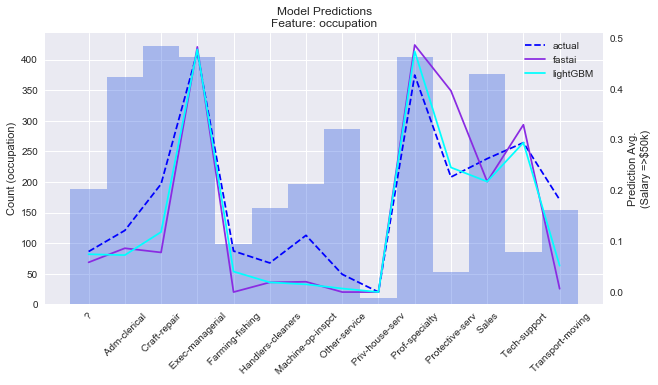

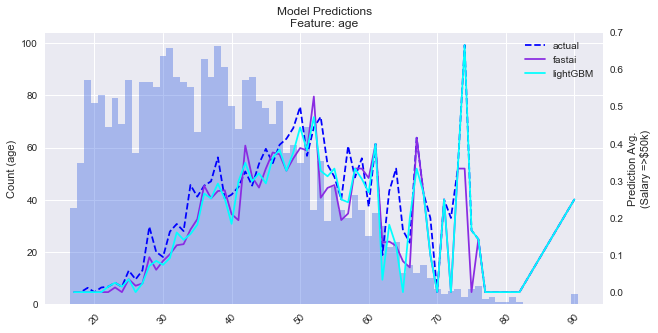

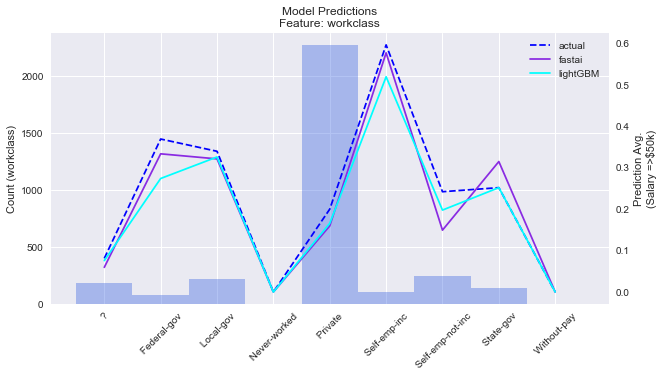

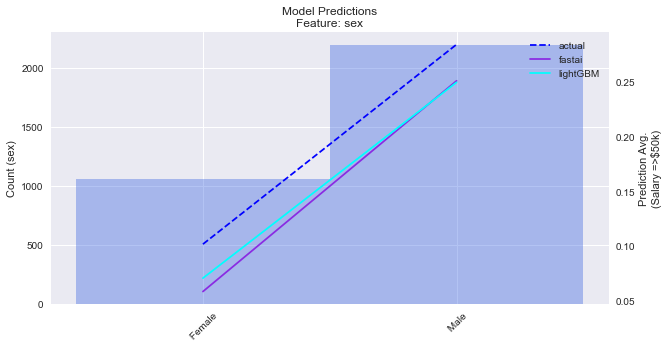

In [408]:
cols = ['occupation', 'age', 'workclass', 'sex']

def plot_feature(col):
    g = dx.groupby(col)[['target', 'nn_preds', 'lgb_preds']].agg(['count', 'mean'])

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()

    ax1.bar(g.index, g['target', 'count'], width=1, alpha=0.4, color='royalblue')
    ax2.plot(g['target', 'mean'], '--b', label='actual') 
    ax2.plot(g['nn_preds', 'mean'], 'blueviolet', label='fastai') 
    ax2.plot(g['lgb_preds', 'mean'], 'aqua', label='lightGBM') 

    ax2.grid(b=False)  # turn off second axis

    ax1.tick_params(axis='x', labelrotation=45)
    ax1.set_title(f'Model Predictions\nFeature: {col}')
    ax1.set_ylabel(f'Count ({col})')
    ax2.set_ylabel('Prediction Avg.\n(Salary =>$50k)')
    
    plt.legend()
    plt.show()
    
for col in cols:
    plot_feature(col)